# Petri Net Discovery: Sequencial & Loop & Parallel Workflow Patterns

## Step 1: Setup

In [1]:
import pandas as pd
import pm4py
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.util import dataframe_utils
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.visualization.petri_net import visualizer as pn_visualizer

## Step 2: Load Event Log from CSV

In [2]:
df = pd.read_csv("2D_event_log_engagement.csv", sep=';',parse_dates=["timestamp"])
df.head()

,timestamp,location,day,report_case_id,simpler_event_type,Unnamed: 5
0,09/05/2025 08:51,home,09/05/2025,1,notification_RECEIVED,NaN
1,09/05/2025 08:51,home,09/05/2025,1,notification_READ,NaN
2,09/05/2025 08:52,home,09/05/2025,1,self-report_high,NaN
3,09/05/2025 11:55,other,09/05/2025,2,notification_RECEIVED,NaN
4,09/05/2025 11:55,other,09/05/2025,2,notification_READ,NaN


## Step 3: Prepare the Event Log
PM4Py expects specific column names. Let's rename them and sort the log by time within each case.

In [3]:
# Rename columns to PM4Py convention
df = df.rename(columns={
    "timestamp": "time:timestamp",
    "report_case_id": "case:concept:name",
    "simpler_event_type": "concept:name"
})

# Sort by case and time
df = dataframe_utils.convert_timestamp_columns_in_df(df)
df = df.sort_values(by=["case:concept:name", "time:timestamp"])
#df['case:concept:name'] = df['case:concept:name'].dt.strftime('%Y-%m-%d')

# Ensure concept:name is string type
df['concept:name'] = df['concept:name'].astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 163 entries, 0 to 39
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   time:timestamp     163 non-null    datetime64[ns, UTC]
 1   location           163 non-null    object             
 2   day                163 non-null    datetime64[ns, UTC]
 3   case:concept:name  163 non-null    int64              
 4   concept:name       163 non-null    object             
 5   Unnamed: 5         0 non-null      float64            
dtypes: datetime64[ns, UTC](2), float64(1), int64(1), object(2)
memory usage: 8.9+ KB


## Step 4: Convert to PM4Py Event Log

In [4]:
from pm4py.objects.conversion.log import converter as log_converter

event_log = log_converter.apply(df, variant=log_converter.Variants.TO_EVENT_LOG)

## Step 5: Discover the Process Tree Using Inductive Miner

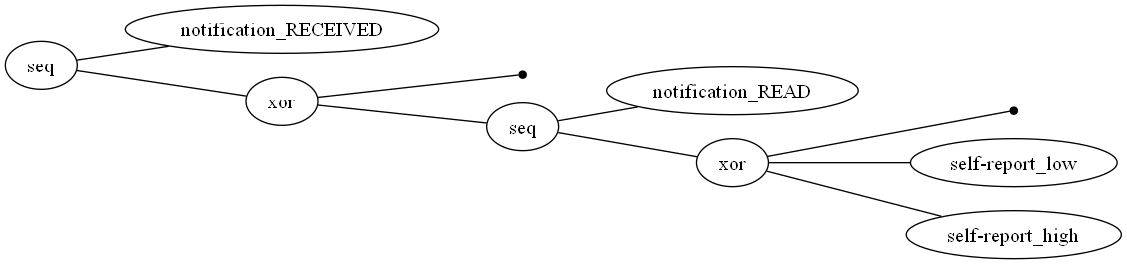

In [5]:
## Discover Process Model
# First get the process tree
process_tree = inductive_miner.apply(event_log)

# Visualize Process Tree
from pm4py.visualization.process_tree import visualizer as pt_visualizer
gviz_pt = pt_visualizer.apply(process_tree)
pt_visualizer.view(gviz_pt)



## Step 6: Converting to Petri Net

In [6]:
# Convert process tree to Petri net
from pm4py.objects.conversion.process_tree import converter as pt_converter
net, initial_marking, final_marking = pt_converter.apply(process_tree)

## Step 7: Visualizing the Petri Net

Simple Petri Net 

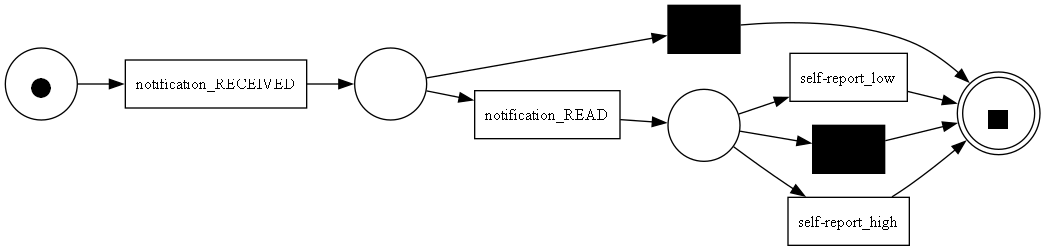

In [7]:
gviz = pn_visualizer.apply(net, initial_marking, final_marking, 
                          log=event_log)
pn_visualizer.view(gviz)

In [8]:
net.transitions

{(35db0d5c-39b9-462c-b251-69be473362f8, 'self-report_low'),
 (3dbd82a2-30da-4ba5-907b-eaa987241c66, 'notification_RECEIVED'),
 (401b435d-9d47-4f6f-bf68-23ec24e7850b, 'notification_READ'),
 (b3cb7c29-7449-4e8e-820f-b6d2254de1fb, 'self-report_high'),
 (skip_1, None),
 (skip_2, None)}

Petri Net with frequency statistics

replaying log with TBR, completed traces ::   0%|          | 0/4 [00:00<?, ?it/s]

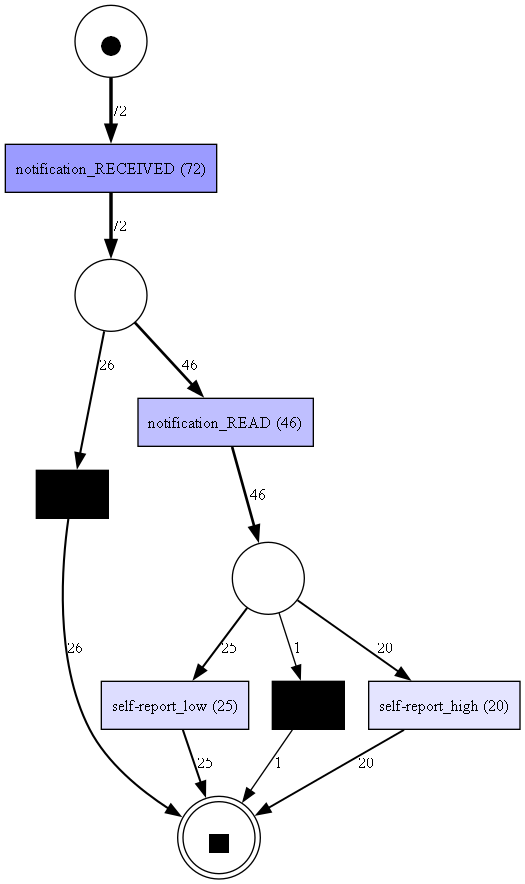

In [9]:
# Visualizing
# For frequency-based visualization
parameters = {
    pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png",
    pn_visualizer.Variants.FREQUENCY.value.Parameters.DEBUG: False,
    pn_visualizer.Variants.FREQUENCY.value.Parameters.RANKDIR: "TB"
}
gviz = pn_visualizer.apply(net, initial_marking, final_marking, 
                          variant=pn_visualizer.Variants.FREQUENCY,
                          parameters=parameters,
                          log=event_log)
pn_visualizer.view(gviz)

Petri net with time statistics

replaying log with TBR, completed traces ::   0%|          | 0/4 [00:00<?, ?it/s]

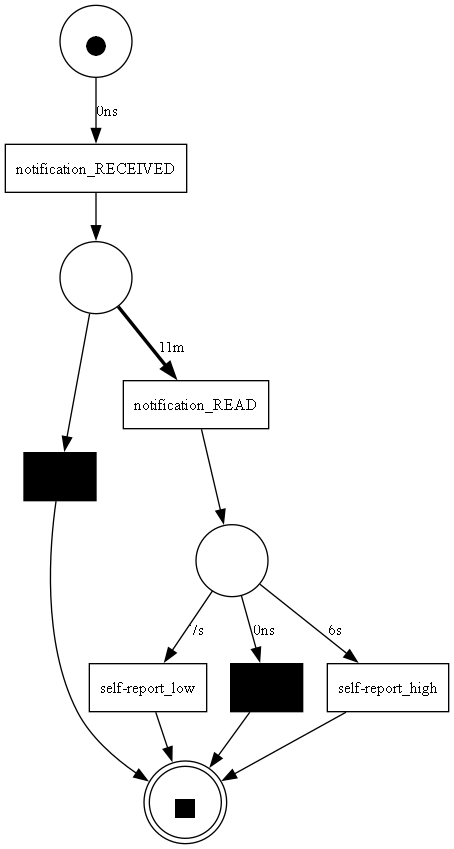

In [10]:
# Convert process tree to Petri net
# For performance-based visualization (showing time statistics)
# Convert timestamps if they're not in datetime format
if isinstance(event_log[0][0]['time:timestamp'], str):
    for trace in event_log:
        for event in trace:
            event['time:timestamp'] = pd.to_datetime(event['time:timestamp'])


parameters = {
    pn_visualizer.Variants.PERFORMANCE.value.Parameters.FORMAT: "png",
    pn_visualizer.Variants.PERFORMANCE.value.Parameters.DEBUG: False,
    pn_visualizer.Variants.PERFORMANCE.value.Parameters.RANKDIR: "TB",
    pn_visualizer.Variants.PERFORMANCE.value.Parameters.AGGREGATION_MEASURE: "mean",  # or "median", "min", "max"
    pn_visualizer.Variants.PERFORMANCE.value.Parameters.ACTIVITY_KEY: "concept:name",
    pn_visualizer.Variants.PERFORMANCE.value.Parameters.TIMESTAMP_KEY: "time:timestamp"
}
gviz = pn_visualizer.apply(net, initial_marking, final_marking, 
                          variant=pn_visualizer.Variants.PERFORMANCE,
                          parameters=parameters,
                          log=event_log)
pn_visualizer.view(gviz)

## Data Aware Mining

In [11]:
# Initialize the miner (as before)
import sys
sys.path.append('..')
from src.data_aware_mining import DataAwareProcessMining
miner = DataAwareProcessMining(net, initial_marking, final_marking, event_log)
print(event_log)

[{'attributes': {'concept:name': 1}, 'events': [{'time:timestamp': Timestamp('2025-09-05 08:51:00+0000', tz='UTC'), 'location': 'home', 'day': Timestamp('2025-09-05 00:00:00+0000', tz='UTC'), 'concept:name': 'notification_RECEIVED', 'Unnamed: 5': nan}, '..', {'time:timestamp': Timestamp('2025-09-05 08:52:00+0000', tz='UTC'), 'location': 'home', 'day': Timestamp('2025-09-05 00:00:00+0000', tz='UTC'), 'concept:name': 'self-report_high', 'Unnamed: 5': nan}]}, '....', {'attributes': {'concept:name': 80}, 'events': [{'time:timestamp': Timestamp('2025-11-05 20:58:00+0000', tz='UTC'), 'location': 'invalid', 'day': Timestamp('2025-11-05 00:00:00+0000', tz='UTC'), 'concept:name': 'notification_RECEIVED', 'Unnamed: 5': nan}, '..', {'time:timestamp': Timestamp('2025-11-05 21:02:00+0000', tz='UTC'), 'location': 'invalid', 'day': Timestamp('2025-11-05 00:00:00+0000', tz='UTC'), 'concept:name': 'self-report_low', 'Unnamed: 5': nan}]}]


In [12]:
# First detect choice points
choice_points = miner.detect_choice_points()
miner.get_choice_point_names()
choice_points


=== Detecting Choice Points ===
All transitions in net:
  - 35db0d5c-39b9-462c-b251-69be473362f8 (label: self-report_low)
  - skip_1 (label: None)
  - 401b435d-9d47-4f6f-bf68-23ec24e7850b (label: notification_READ)
  - 3dbd82a2-30da-4ba5-907b-eaa987241c66 (label: notification_RECEIVED)
  - skip_2 (label: None)
  - b3cb7c29-7449-4e8e-820f-b6d2254de1fb (label: self-report_high)

All places in net:
  - source
    Outgoing arcs:
      -> 3dbd82a2-30da-4ba5-907b-eaa987241c66 (label: notification_RECEIVED)
    Incoming arcs:
  - p_3
    Outgoing arcs:
      -> skip_1 (label: None)
      -> 401b435d-9d47-4f6f-bf68-23ec24e7850b (label: notification_READ)
    Incoming arcs:
      <- 3dbd82a2-30da-4ba5-907b-eaa987241c66 (label: notification_RECEIVED)
  - p_4
    Outgoing arcs:
      -> skip_2 (label: None)
      -> 35db0d5c-39b9-462c-b251-69be473362f8 (label: self-report_low)
      -> b3cb7c29-7449-4e8e-820f-b6d2254de1fb (label: self-report_high)
    Incoming arcs:
      <- 401b435d-9d47-4f6f-b

In [13]:
# First see what transitions and labels you have
miner.print_transition_labels()


Current transition labels in net:
Transition: 35db0d5c-39b9-462c-b251-69be473362f8
  Label: self-report_low
Transition: skip_1
  Label: (no label)
Transition: 401b435d-9d47-4f6f-bf68-23ec24e7850b
  Label: notification_READ
Transition: 3dbd82a2-30da-4ba5-907b-eaa987241c66
  Label: notification_RECEIVED
Transition: skip_2
  Label: (no label)
Transition: b3cb7c29-7449-4e8e-820f-b6d2254de1fb
  Label: self-report_high


In [14]:
print(net.transitions)

# For each transition you want to label
for trans in net.transitions:
    if trans.name == 'skip_1':
        trans.label = 'sink'
        trans.name = 'sink'
    if trans.name == 'skip_2':
        trans.label = 'sink'
#net.transitions
print(net.arcs)

{(35db0d5c-39b9-462c-b251-69be473362f8, 'self-report_low'), (skip_1, None), (401b435d-9d47-4f6f-bf68-23ec24e7850b, 'notification_READ'), (3dbd82a2-30da-4ba5-907b-eaa987241c66, 'notification_RECEIVED'), (skip_2, None), (b3cb7c29-7449-4e8e-820f-b6d2254de1fb, 'self-report_high')}
{p_3->(sink, 'sink'), (3dbd82a2-30da-4ba5-907b-eaa987241c66, 'notification_RECEIVED')->p_3, (401b435d-9d47-4f6f-bf68-23ec24e7850b, 'notification_READ')->p_4, p_4->(skip_2, 'sink'), (35db0d5c-39b9-462c-b251-69be473362f8, 'self-report_low')->sink, p_4->(b3cb7c29-7449-4e8e-820f-b6d2254de1fb, 'self-report_high'), source->(3dbd82a2-30da-4ba5-907b-eaa987241c66, 'notification_RECEIVED'), (sink, 'sink')->sink, p_3->(401b435d-9d47-4f6f-bf68-23ec24e7850b, 'notification_READ'), (skip_2, 'sink')->sink, p_4->(35db0d5c-39b9-462c-b251-69be473362f8, 'self-report_low'), (b3cb7c29-7449-4e8e-820f-b6d2254de1fb, 'self-report_high')->sink}


In [20]:
# Mine a decision tree for a specific choice point
# For example, if you have a place named "p1" and want to use attributes "age" and "priority"
result = miner.mine_decision_tree(
    place_name="p_4",
    attributes=["location"],
    max_depth=2  # optional: limit tree depth
)


=== Mining Decision Tree ===
Place: p_4
Attributes: ['location']

Found 3 transitions for this choice point:
  - skip_2 (label: sink)
  - 35db0d5c-39b9-462c-b251-69be473362f8 (label: self-report_low)
  - b3cb7c29-7449-4e8e-820f-b6d2254de1fb (label: self-report_high /  @home; p=0.667)

=== Finding Traces for Choice Point ===
Looking for traces at place: p_4
  Transition: skip_2
    Label: sink
  Transition: 35db0d5c-39b9-462c-b251-69be473362f8
    Label: self-report_low
  Transition: b3cb7c29-7449-4e8e-820f-b6d2254de1fb
    Label: self-report_high /  @home; p=0.667

Transitions that can be taken from this place (by label):
  - sink (transition: skip_2)
  - self-report_low (transition: 35db0d5c-39b9-462c-b251-69be473362f8)
  - self-report_high /  @home; p=0.667 (transition: b3cb7c29-7449-4e8e-820f-b6d2254de1fb)

Processing trace 1
Number of events: 3

  Checking event 0: notification_RECEIVED

  Checking event 1: notification_READ

  Checking event 2: self-report_high

Processing trace 

In [16]:
# Get the decision rules in a readable format
rules = miner.get_decision_tree_rules("p_3")
print("Decision Rules:")
print(rules)

Decision Rules:
Decision Rules for p_3:

Attribute Encodings:

location:
  gym -> 0
  home -> 1
  in_transit -> 2
  invalid -> 3
  other -> 4
  work -> 5

Transition Encodings (by label):
  notification_READ -> 0

Decision Tree Structure:
|--- class: notification_READ


Feature Importances:
  location: 0.000

Class Distribution:
  notification_READ: 46 samples (100.0%)


In [17]:
# Get feature importances
importances = miner.get_feature_importances("p_3")
print("\nFeature Importances:")
for attr, importance in importances.items():
    print(f"{attr}: {importance:.3f}")

# Make a prediction for a new case
prediction = miner.predict_transition(
    place_name="p_3",
    state={
        "location": "home"	
    }
)
print(f"\nPredicted transition: {prediction}")


Feature Importances:
location: 0.000

Prediction details:
Input state: {'location': 'home'}
Encoded features:
  location: home -> 1

Predicted transition: notification_READ
Transition probabilities:
  notification_READ: 1.000

Predicted transition: notification_READ


In [18]:
# For each transition you want to label
for trans in net.transitions:
    if trans.name == 'init_loop_3':
        trans.label = 'physical_activity_START /  @home; p=0.333'
    if trans.label == 'self-report_high':
        trans.label = 'self-report_high /  @home; p=0.667'

replaying log with TBR, completed traces ::   0%|          | 0/4 [00:00<?, ?it/s]

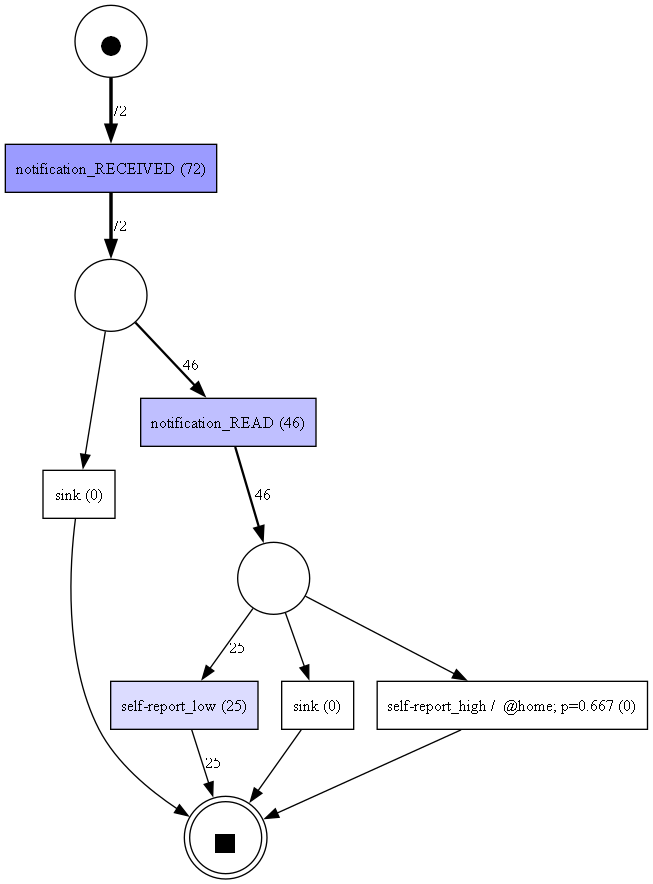

In [19]:
# Visualizing
# For frequency-based visualization
parameters = {
    pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png",
    pn_visualizer.Variants.FREQUENCY.value.Parameters.DEBUG: False,
    pn_visualizer.Variants.FREQUENCY.value.Parameters.RANKDIR: "TB"
}
gviz = pn_visualizer.apply(net, initial_marking, final_marking, 
                          variant=pn_visualizer.Variants.FREQUENCY,
                          parameters=parameters,
                          log=event_log)
pn_visualizer.view(gviz)